# Scenario X Config -> score training with Random Forest Regression

In [9]:
# import os 
# os.environ["MODIN_ENGINE"] = "ray"
# import modin.pandas as modin_pd

# import dask.dataframe as dd

import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from ad_config_search.utils import get_rows
RSEED = 50

## Load tables and clean data

In [2]:
# Load in data
with open("df_configs_5sectors.pl", 'rb') as f:
    config_df = pickle.load(f)
config_df

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score,metric
0,training_0000-S23-P0_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,30.547550,T_mota
1,training_0000-S23-P1_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,39.197930,T_mota
2,training_0000-S23-P2_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,37.049861,T_mota
3,training_0000-S23-P3_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,28.266494,T_mota
4,training_0000-S23-P4_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,29.371688,T_mota
...,...,...,...,...,...,...,...,...,...,...
1704955,training_0003-S1-P0_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-9.959350,T_mota
1704956,training_0003-S1-P1_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-3.034682,T_mota
1704957,training_0003-S1-P2_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-10.264901,T_mota
1704958,training_0003-S1-P3_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-27.734375,T_mota


In [3]:
config_df = config_df[config_df["D-seq-pol"] != "infinite"]  # filter out infinite runs
config_df["D-conf"] = config_df["D-conf"].astype(float)
config_df["T-min-iou"] = config_df["T-min-iou"].astype(float)
config_df["T-max-age"] = config_df["T-max-age"].astype(int)
config_df["T-every-nth-det"] = config_df["T-every-nth-det"].astype(int)
config_df = config_df.drop(columns=["metric"])
config_df["score"] = config_df["score"].astype(float)
config_df

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score
0,training_0000-S23-P0_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,30.547550
1,training_0000-S23-P1_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,39.197930
2,training_0000-S23-P2_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,37.049861
3,training_0000-S23-P3_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,28.266494
4,training_0000-S23-P4_5,efficientdet-d5,0.5,eager,sort,0.3,5,1,29.371688
...,...,...,...,...,...,...,...,...,...
1704955,training_0003-S1-P0_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-9.959350
1704956,training_0003-S1-P1_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-3.034682
1704957,training_0003-S1-P2_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-10.264901
1704958,training_0003-S1-P3_5,efficientdet-d6,0.3,eager,sort,0.5,3,3,-27.734375


In [35]:
with open("oracle_k_10_policy.pl", 'rb') as f:
    oracle_k_10_policy = pickle.load(f)
import json
oracle_k_10_configs = [json.loads(s) for s in np.unique([json.dumps(c) for c in oracle_k_10_policy.values()])]
len(oracle_k_10_configs)

50

In [21]:
config_df = pd.concat([get_rows(config_df, c) for c in tqdm(oracle_k_10_configs)])

100%|██████████| 50/50 [00:11<00:00,  4.49it/s]


In [22]:
scenario_feats_df = pd.read_csv("../data/scenario_features_v3_fine_4s.csv")
scenario_feats_df

,Unnamed: 0,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,weather,location,scenario_name
0,0,40.000000,40.0,1.0,85.656465,4230.876055,1.000000,59.791686,2307.979946,9.839008,Day,sunny,location_sf,training_0004-S_24-P0_5
1,1,12.000000,12.0,1.0,108.158862,11963.348346,0.300000,21.910720,2870.257797,9.867627,Day,sunny,location_sf,training_0004-S_24-P1_5
2,2,6.000000,11.0,3.0,203.228819,3270.956020,0.750000,47.303100,952.989819,9.172085,Day,sunny,location_sf,training_0004-S_24-P2_5
3,3,36.833333,40.0,6.0,280.682187,20169.298040,5.525000,220.192392,8177.688289,8.852530,Day,sunny,location_sf,training_0004-S_24-P3_5
4,4,25.428571,39.0,6.0,209.327258,3387.636791,4.564103,170.470484,2728.638435,6.345968,Day,sunny,location_sf,training_0004-S_24-P4_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222,1222,25.140000,40.0,35.0,49.665209,873.811803,31.425000,40.964967,613.666850,20.180857,Day,sunny,location_phx,training_0006-S_23-P0_5
1223,1223,21.102041,40.0,28.0,47.115496,1784.374827,25.850000,37.469432,1222.445215,19.504756,Day,sunny,location_phx,training_0006-S_23-P1_5
1224,1224,27.405405,40.0,28.0,53.371373,2593.207268,25.350000,46.546113,2069.365273,14.931406,Day,sunny,location_phx,training_0006-S_23-P2_5
1225,1225,29.921053,40.0,31.0,66.133055,6546.779569,28.425000,48.762617,4481.260176,8.980759,Day,sunny,location_phx,training_0006-S_23-P3_5


In [23]:
scenario_feats_df.columns

Index(['Unnamed: 0', 'avg_bbox_longevity', '90p_bbox_longevity',
       '90p_num_bboxes', '90p_bbox_speed', '90p_bbox_size', 'avg_num_bboxes',
       'avg_bbox_speed', 'avg_bbox_size', 'avg_ego_speed', 'time_of_day',
       'weather', 'location', 'scenario_name'],
      dtype='object')

In [24]:
scenario_feats_df = scenario_feats_df.loc[:, ~scenario_feats_df.columns.str.contains('^Unnamed')]
scenario_feats_df = scenario_feats_df.drop(columns=["weather"])  # weather column is all the same
scenario_feats_df["scenario_name"] = scenario_feats_df["scenario_name"].apply(lambda x: x.replace("-S_", "-S"))
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,location,scenario_name
0,40.000000,40.0,1.0,85.656465,4230.876055,1.000000,59.791686,2307.979946,9.839008,Day,location_sf,training_0004-S24-P0_5
1,12.000000,12.0,1.0,108.158862,11963.348346,0.300000,21.910720,2870.257797,9.867627,Day,location_sf,training_0004-S24-P1_5
2,6.000000,11.0,3.0,203.228819,3270.956020,0.750000,47.303100,952.989819,9.172085,Day,location_sf,training_0004-S24-P2_5
3,36.833333,40.0,6.0,280.682187,20169.298040,5.525000,220.192392,8177.688289,8.852530,Day,location_sf,training_0004-S24-P3_5
4,25.428571,39.0,6.0,209.327258,3387.636791,4.564103,170.470484,2728.638435,6.345968,Day,location_sf,training_0004-S24-P4_5
...,...,...,...,...,...,...,...,...,...,...,...,...
1222,25.140000,40.0,35.0,49.665209,873.811803,31.425000,40.964967,613.666850,20.180857,Day,location_phx,training_0006-S23-P0_5
1223,21.102041,40.0,28.0,47.115496,1784.374827,25.850000,37.469432,1222.445215,19.504756,Day,location_phx,training_0006-S23-P1_5
1224,27.405405,40.0,28.0,53.371373,2593.207268,25.350000,46.546113,2069.365273,14.931406,Day,location_phx,training_0006-S23-P2_5
1225,29.921053,40.0,31.0,66.133055,6546.779569,28.425000,48.762617,4481.260176,8.980759,Day,location_phx,training_0006-S23-P3_5


In [25]:
scenario_feats_df

,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,location,scenario_name
0,40.000000,40.0,1.0,85.656465,4230.876055,1.000000,59.791686,2307.979946,9.839008,Day,location_sf,training_0004-S24-P0_5
1,12.000000,12.0,1.0,108.158862,11963.348346,0.300000,21.910720,2870.257797,9.867627,Day,location_sf,training_0004-S24-P1_5
2,6.000000,11.0,3.0,203.228819,3270.956020,0.750000,47.303100,952.989819,9.172085,Day,location_sf,training_0004-S24-P2_5
3,36.833333,40.0,6.0,280.682187,20169.298040,5.525000,220.192392,8177.688289,8.852530,Day,location_sf,training_0004-S24-P3_5
4,25.428571,39.0,6.0,209.327258,3387.636791,4.564103,170.470484,2728.638435,6.345968,Day,location_sf,training_0004-S24-P4_5
...,...,...,...,...,...,...,...,...,...,...,...,...
1222,25.140000,40.0,35.0,49.665209,873.811803,31.425000,40.964967,613.666850,20.180857,Day,location_phx,training_0006-S23-P0_5
1223,21.102041,40.0,28.0,47.115496,1784.374827,25.850000,37.469432,1222.445215,19.504756,Day,location_phx,training_0006-S23-P1_5
1224,27.405405,40.0,28.0,53.371373,2593.207268,25.350000,46.546113,2069.365273,14.931406,Day,location_phx,training_0006-S23-P2_5
1225,29.921053,40.0,31.0,66.133055,6546.779569,28.425000,48.762617,4481.260176,8.980759,Day,location_phx,training_0006-S23-P3_5


### Join tables, one-hot encode

In [26]:
x = set(config_df["run"])
y = set(scenario_feats_df["scenario_name"])
x.difference(y), y.difference(x)

({'training_0001-S15-P2_5',
  'training_0001-S3-P4_5',
  'training_0002-S21-P3_5',
  'training_0004-S7-P2_5',
  'training_0004-S7-P3_5',
  'training_0005-S20-P0_5',
  'training_0005-S20-P1_5',
  'training_0005-S20-P4_5',
  'training_0005-S23-P0_5',
  'training_0005-S4-P3_5',
  'training_0005-S4-P4_5'},
 {'training_0006-S0-P0_5',
  'training_0006-S0-P1_5',
  'training_0006-S0-P2_5',
  'training_0006-S0-P3_5',
  'training_0006-S0-P4_5',
  'training_0006-S1-P0_5',
  'training_0006-S1-P1_5',
  'training_0006-S1-P2_5',
  'training_0006-S1-P3_5',
  'training_0006-S1-P4_5',
  'training_0006-S10-P0_5',
  'training_0006-S10-P1_5',
  'training_0006-S10-P2_5',
  'training_0006-S10-P3_5',
  'training_0006-S10-P4_5',
  'training_0006-S11-P0_5',
  'training_0006-S11-P1_5',
  'training_0006-S11-P2_5',
  'training_0006-S11-P3_5',
  'training_0006-S11-P4_5',
  'training_0006-S12-P0_5',
  'training_0006-S12-P1_5',
  'training_0006-S12-P2_5',
  'training_0006-S12-P3_5',
  'training_0006-S12-P4_5',
  'tra

In [27]:
joined_df = config_df.set_index('run').join(scenario_feats_df.set_index('scenario_name'), lsuffix="_config_df", rsuffix="_scenario_df", how="inner")
# assert not joined_df.isnull().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
# assert not joined_df.isna().values.any(), "Some values are Nan after join, it means some scenarios in config_df don't show up in scenario_df"
joined_df

,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,score,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,avg_bbox_speed,avg_bbox_size,avg_ego_speed,time_of_day,location
training_0000-S0-P0_5,efficientdet-d1,0.3,tail-aware,sort,0.1,1,3,25.555556,18.800000,36.0,10.1,135.227854,36462.177860,7.050000,82.293223,26078.894492,5.517220,Day,location_sf
training_0000-S0-P0_5,efficientdet-d1,0.5,eager,sort,0.1,3,1,26.937269,18.800000,36.0,10.1,135.227854,36462.177860,7.050000,82.293223,26078.894492,5.517220,Day,location_sf
training_0000-S0-P0_5,efficientdet-d1,0.5,tail-aware,sort,0.1,1,1,27.306273,18.800000,36.0,10.1,135.227854,36462.177860,7.050000,82.293223,26078.894492,5.517220,Day,location_sf
training_0000-S0-P0_5,efficientdet-d2,0.3,wait,sort,0.1,7,1,26.199262,18.800000,36.0,10.1,135.227854,36462.177860,7.050000,82.293223,26078.894492,5.517220,Day,location_sf
training_0000-S0-P0_5,efficientdet-d2,0.5,eager,sort,0.1,7,3,23.333333,18.800000,36.0,10.1,135.227854,36462.177860,7.050000,82.293223,26078.894492,5.517220,Day,location_sf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S9-P4_5,efficientdet-d7x,0.5,tail-aware,sort,0.1,1,1,28.938156,30.607143,38.0,24.0,13.083428,2655.662579,22.552632,8.904308,1774.223721,2.669348,Day,location_phx
training_0005-S9-P4_5,efficientdet-d7x,0.5,tail-aware,sort,0.1,7,3,28.821470,30.607143,38.0,24.0,13.083428,2655.662579,22.552632,8.904308,1774.223721,2.669348,Day,location_phx
training_0005-S9-P4_5,efficientdet-d7x,0.5,tail-aware,sort,0.1,7,5,29.638273,30.607143,38.0,24.0,13.083428,2655.662579,22.552632,8.904308,1774.223721,2.669348,Day,location_phx
training_0005-S9-P4_5,efficientdet-d7x,0.5,wait,sort,0.1,3,1,29.404901,30.607143,38.0,24.0,13.083428,2655.662579,22.552632,8.904308,1774.223721,2.669348,Day,location_phx


In [28]:
joined_df = pd.get_dummies(joined_df, prefix_sep="__")
joined_df["scenario_name"] = joined_df.index.map(lambda x: "-".join(x.split("-")[:2]))
joined_df

,D-conf,T-min-iou,T-max-age,T-every-nth-det,score,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,...,D-seq-pol__tail-aware,D-seq-pol__wait,T-model__sort,time_of_day__Dawn/Dusk,time_of_day__Day,time_of_day__Night,location__location_other,location__location_phx,location__location_sf,scenario_name
training_0000-S0-P0_5,0.3,0.1,1,3,25.555556,18.800000,36.0,10.1,135.227854,36462.177860,...,1,0,1,0,1,0,0,0,1,training_0000-S0
training_0000-S0-P0_5,0.5,0.1,3,1,26.937269,18.800000,36.0,10.1,135.227854,36462.177860,...,0,0,1,0,1,0,0,0,1,training_0000-S0
training_0000-S0-P0_5,0.5,0.1,1,1,27.306273,18.800000,36.0,10.1,135.227854,36462.177860,...,1,0,1,0,1,0,0,0,1,training_0000-S0
training_0000-S0-P0_5,0.3,0.1,7,1,26.199262,18.800000,36.0,10.1,135.227854,36462.177860,...,0,1,1,0,1,0,0,0,1,training_0000-S0
training_0000-S0-P0_5,0.5,0.1,7,3,23.333333,18.800000,36.0,10.1,135.227854,36462.177860,...,0,0,1,0,1,0,0,0,1,training_0000-S0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S9-P4_5,0.5,0.1,1,1,28.938156,30.607143,38.0,24.0,13.083428,2655.662579,...,1,0,1,0,1,0,0,1,0,training_0005-S9
training_0005-S9-P4_5,0.5,0.1,7,3,28.821470,30.607143,38.0,24.0,13.083428,2655.662579,...,1,0,1,0,1,0,0,1,0,training_0005-S9
training_0005-S9-P4_5,0.5,0.1,7,5,29.638273,30.607143,38.0,24.0,13.083428,2655.662579,...,1,0,1,0,1,0,0,1,0,training_0005-S9
training_0005-S9-P4_5,0.5,0.1,3,1,29.404901,30.607143,38.0,24.0,13.083428,2655.662579,...,0,1,1,0,1,0,0,1,0,training_0005-S9


## Prep training

In [29]:
# Extract the labels
labels = np.array(joined_df.pop('score'))

### Scenario examples are fairly balanced, so we just do train-test and cross-v splits across scenario boundaries

<AxesSubplot:xlabel='scenario_name', ylabel='Count'>

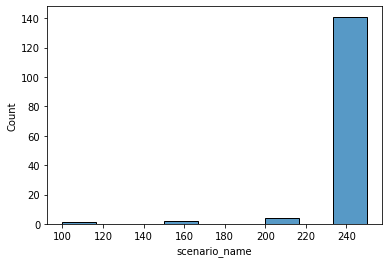

In [38]:
counts = joined_df["scenario_name"].value_counts()
sns.histplot(counts)

#### Manual train-test split across scenario boundaries

In [40]:
import random
unique_scenarios = list(joined_df["scenario_name"].unique())
unique_scenarios = sorted(unique_scenarios)
random.shuffle(unique_scenarios, random=lambda: 0.43)
train_scenarios = unique_scenarios[len(unique_scenarios)//3:]
test_scenarios = unique_scenarios[:len(unique_scenarios)//3]

train, train_labels = joined_df[joined_df["scenario_name"].isin(train_scenarios)], labels[joined_df["scenario_name"].isin(train_scenarios)]
test, test_labels = joined_df[joined_df["scenario_name"].isin(test_scenarios)], labels[joined_df["scenario_name"].isin(test_scenarios)]

In [41]:
train_scenarios

['training_0004-S3',
 'training_0000-S7',
 'training_0004-S7',
 'training_0000-S8',
 'training_0005-S10',
 'training_0000-S9',
 'training_0005-S15',
 'training_0005-S17',
 'training_0001-S0',
 'training_0005-S21',
 'training_0001-S1',
 'training_0005-S3',
 'training_0001-S10',
 'training_0005-S8',
 'training_0002-S23',
 'training_0001-S11',
 'training_0002-S3',
 'training_0001-S12',
 'training_0002-S5',
 'training_0001-S13',
 'training_0002-S7',
 'training_0002-S8',
 'training_0001-S14',
 'training_0003-S0',
 'training_0001-S15',
 'training_0003-S10',
 'training_0001-S16',
 'training_0003-S12',
 'training_0003-S13',
 'training_0001-S17',
 'training_0003-S15',
 'training_0001-S18',
 'training_0003-S17',
 'training_0001-S19',
 'training_0003-S19',
 'training_0003-S2',
 'training_0001-S2',
 'training_0003-S21',
 'training_0001-S20',
 'training_0003-S23',
 'training_0001-S21',
 'training_0003-S3',
 'training_0003-S4',
 'training_0001-S22',
 'training_0003-S6',
 'training_0001-S23',
 'train

In [42]:
train = train.drop(columns=["scenario_name"])
test = test.drop(columns=["scenario_name"])

#### Automated cross-validation splitter across scenario boundaries

In [43]:
# Features for feature importances
features = list(train.columns)
features, len(features)

(['D-conf',
  'T-min-iou',
  'T-max-age',
  'T-every-nth-det',
  'avg_bbox_longevity',
  '90p_bbox_longevity',
  '90p_num_bboxes',
  '90p_bbox_speed',
  '90p_bbox_size',
  'avg_num_bboxes',
  'avg_bbox_speed',
  'avg_bbox_size',
  'avg_ego_speed',
  'D-model__efficientdet-d1',
  'D-model__efficientdet-d2',
  'D-model__efficientdet-d3',
  'D-model__efficientdet-d4',
  'D-model__efficientdet-d5',
  'D-model__efficientdet-d6',
  'D-model__efficientdet-d7',
  'D-model__efficientdet-d7x',
  'D-seq-pol__eager',
  'D-seq-pol__tail-aware',
  'D-seq-pol__wait',
  'T-model__sort',
  'time_of_day__Dawn/Dusk',
  'time_of_day__Day',
  'time_of_day__Night',
  'location__location_other',
  'location__location_phx',
  'location__location_sf'],
 31)

### Do a bit of a cross-val hyperparameter search. This is very rudimentary.

In [44]:
# Create the model with 100 trees
model = RandomForestRegressor(n_estimators=1600, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

In [45]:
from scipy.stats import loguniform, randint

In [46]:
[0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.002,0.005,0.01]

[5e-05, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01]

In [47]:
x = loguniform(0.00005, 0.05, scale=2).rvs(size=10000)

(array([6646., 1027.,  564.,  402.,  334.,  292.,  224.,  181.,  182.,
         148.]),
 array([0.00010013, 0.01008544, 0.02007074, 0.03005605, 0.04004135,
        0.05002666, 0.06001197, 0.06999727, 0.07998258, 0.08996789,
        0.09995319]),
 <BarContainer object of 10 artists>)

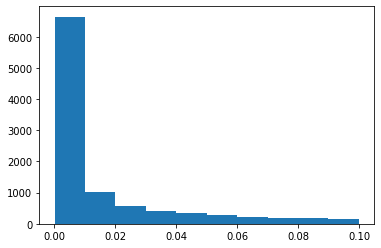

In [48]:
import matplotlib.pyplot as plt
plt.hist(x)

In [49]:
x = randint(3,10).rvs(size=10000)

In [50]:
import matplotlib.pyplot as plt
np.bincount(x)

array([   0,    0,    0, 1442, 1435, 1412, 1412, 1462, 1428, 1409])

In [51]:
# 5:48am start

In [52]:
from ad_config_search.rforest_utils import ScenarioAwareCVSplitter

In [ ]:
%%time
clf = RandomizedSearchCV(model, {
    "max_depth": randint(1, 25),
    "max_features": randint(2, 24),
    "n_estimators": [200, 400, 800, 1600, 2400],
    "min_impurity_decrease": loguniform(0.00005, 0.05, scale=2)
}, cv=ScenarioAwareCVSplitter(n_splits=5, shuffle=True, random_state=RSEED), n_iter=100)
clf.fit(train, train_labels)

<class 'pandas.core.frame.DataFrame'>


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 out of 200 | elapsed:    4.7s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 114 out of 200 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=144)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 out of 200 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 114 out of 200 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=144)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concur

In [54]:
# per-scenario grained
clf.cv_results_

{'mean_fit_time': array([1.74958267, 2.80145597, 6.48357983, 1.03626213, 1.0140976 ,
        2.93601074, 3.09417405, 1.09135976, 1.98263555, 3.21953845,
        7.81049051, 0.99534807, 1.76040773, 3.04820814, 2.92213635,
        0.93095961, 1.76330562, 1.8506793 , 2.90171404, 4.85480762,
        8.18014584, 1.77029133, 3.00533352, 3.15749879, 7.62656693,
        5.16043873, 0.95713701, 0.93632402, 1.94476247, 5.34869962,
        2.86676278, 0.93118634, 0.94332843, 1.7914351 , 7.85578327,
        1.00653768, 1.75431089, 8.04491119, 1.07721367, 3.06285434,
        6.87661219, 3.06579723, 0.98112288, 0.93078151, 1.77044234,
        8.30052404, 1.98601246, 2.01387711, 1.02430215, 1.7181581 ,
        2.98492227, 1.80847893, 5.78170347, 5.11879539, 3.04414849,
        3.15028377, 6.87693911, 2.95684986, 1.81409659, 1.04382992,
        5.18020372, 3.20451298, 6.53652282, 8.94815855, 0.97364941,
        7.54580345, 0.96956224, 5.16365991, 2.99596057, 7.30022717,
        3.33370476, 2.99465842,

In [55]:
# per-scenario grained
clf.best_estimator_

RandomForestRegressor(max_depth=14, max_features=2,
                      min_impurity_decrease=0.00013129602661239418,
                      n_estimators=800, n_jobs=-1, random_state=50, verbose=1)

## Training

In [56]:
# Create the model with 100 trees
model = RandomForestRegressor(
max_depth=14, max_features=2,
                      min_impurity_decrease=0.00013129602661239418,
                      n_estimators=800,
    random_state=RSEED, 
#                               max_features = 'sqrt',
                              n_jobs=-1, verbose = 1)
# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 512 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    2.9s finished


RandomForestRegressor(max_depth=14, max_features=2,
                      min_impurity_decrease=0.00013129602661239418,
                      n_estimators=800, n_jobs=-1, random_state=50, verbose=1)

In [57]:
sorted(zip(features, model.feature_importances_), key=(lambda f: f[1]), reverse=True)

[('avg_num_bboxes', 0.10005660698272548),
 ('avg_bbox_longevity', 0.0981805704804458),
 ('avg_ego_speed', 0.09792782609598864),
 ('avg_bbox_size', 0.09641512204274992),
 ('90p_bbox_size', 0.08966144757911479),
 ('90p_bbox_longevity', 0.08181883206891201),
 ('90p_num_bboxes', 0.07811209352396374),
 ('avg_bbox_speed', 0.07465083547814554),
 ('90p_bbox_speed', 0.07152492688472879),
 ('location__location_other', 0.027903061433726235),
 ('location__location_sf', 0.02111936234630595),
 ('T-max-age', 0.020365064687616594),
 ('T-every-nth-det', 0.0180272704938484),
 ('location__location_phx', 0.016536253374756945),
 ('D-model__efficientdet-d7x', 0.01568195000276777),
 ('D-model__efficientdet-d2', 0.012051796999324627),
 ('D-model__efficientdet-d7', 0.0101082903349845),
 ('D-model__efficientdet-d4', 0.009833824303075075),
 ('D-model__efficientdet-d1', 0.008344391852083962),
 ('D-conf', 0.007086185540822819),
 ('D-model__efficientdet-d6', 0.005926446283261899),
 ('time_of_day__Day', 0.0058460788

In [58]:
n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 4431
Average maximum depth 14


In [59]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_score = model.score(train, train_labels)
print("train score", train_score)

# Testing predictions (to determine performance)
rf_predictions = model.predict(test)
test_score = model.score(test, test_labels)
print("test score", test_score)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.3s
[Parallel(n_jobs=144)]: Done 800 out of 800 | elapsed:    0.4s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 183 tasks      | elapsed:    0.3s
[Parallel(n_jobs=144)]: Done 533 tasks      | elapsed:    0.5s
[Parallel(n_jobs=144)]: Done 800 out of 800 | elapsed:    0.6s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.


train score 0.9201566272191566


[Parallel(n_jobs=144)]: Done 164 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 514 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 800 out of 800 | elapsed:    0.5s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 183 tasks      | elapsed:    0.2s


test score 0.4479632440370763


[Parallel(n_jobs=144)]: Done 533 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 800 out of 800 | elapsed:    0.5s finished


In [61]:
model_type = "RF"
env_window = "40"
time = "present"
env_feats = "gt-v3-fine-4s"
dictionary = {
    "model": model,
    "train": train,
    "train_labels": train_labels,
    "test": test,
    "test_labels": test_labels,
    "metadata": "condensed config space"
}
with open("model={}__env-window={}__time={}__env-feats={}__te={:.2f}.pl".format(model_type, env_window, time, env_feats, test_score), 'wb') as f:
    pickle.dump(dictionary, f)

## Using trained model to get best config and saving

In [62]:
train_copy = train.copy()
train_copy["ground_truth"] = train_labels
test_copy = test.copy()
test_copy["ground_truth"] = test_labels

In [63]:
train_copy["prediction"] = model.predict(train)
test_copy["prediction"] = model.predict(test)

[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 162 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 512 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 800 out of 800 | elapsed:    0.6s finished
[Parallel(n_jobs=144)]: Using backend ThreadingBackend with 144 concurrent workers.
[Parallel(n_jobs=144)]: Done 173 tasks      | elapsed:    0.2s
[Parallel(n_jobs=144)]: Done 523 tasks      | elapsed:    0.4s
[Parallel(n_jobs=144)]: Done 800 out of 800 | elapsed:    0.5s finished


In [64]:
train.index.unique()

Index(['training_0000-S7-P0_5', 'training_0000-S7-P1_5',
       'training_0000-S7-P2_5', 'training_0000-S7-P3_5',
       'training_0000-S7-P4_5', 'training_0000-S8-P0_5',
       'training_0000-S8-P1_5', 'training_0000-S8-P2_5',
       'training_0000-S8-P3_5', 'training_0000-S8-P4_5',
       ...
       'training_0005-S8-P0_5', 'training_0005-S8-P1_5',
       'training_0005-S8-P2_5', 'training_0005-S8-P3_5',
       'training_0005-S8-P4_5', 'training_0005-S9-P0_5',
       'training_0005-S9-P1_5', 'training_0005-S9-P2_5',
       'training_0005-S9-P3_5', 'training_0005-S9-P4_5'],
      dtype='object', length=485)

In [65]:
test.index.unique()

Index(['training_0000-S0-P0_5', 'training_0000-S0-P1_5',
       'training_0000-S0-P2_5', 'training_0000-S0-P3_5',
       'training_0000-S0-P4_5', 'training_0000-S1-P0_5',
       'training_0000-S1-P1_5', 'training_0000-S1-P2_5',
       'training_0000-S1-P3_5', 'training_0000-S1-P4_5',
       ...
       'training_0005-S19-P4_5', 'training_0005-S23-P1_5',
       'training_0005-S23-P2_5', 'training_0005-S23-P3_5',
       'training_0005-S23-P4_5', 'training_0005-S6-P0_5',
       'training_0005-S6-P1_5', 'training_0005-S6-P2_5',
       'training_0005-S6-P3_5', 'training_0005-S6-P4_5'],
      dtype='object', length=244)

In [66]:
train_copy["run_name"] = train_copy.index
test_copy["run_name"] = test_copy.index

In [67]:
to_predict = test_copy

In [68]:
best_predicted_configs = pd.DataFrame([rows.iloc[rows["prediction"].argmax()] for run_name, rows in to_predict.groupby(["run_name"])])

In [69]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,...,T-model__sort,time_of_day__Dawn/Dusk,time_of_day__Day,time_of_day__Night,location__location_other,location__location_phx,location__location_sf,ground_truth,prediction,run_name
training_0000-S0-P0_5,0.3,0.1,3,1,18.800000,36.0,10.1,135.227854,36462.177860,7.050000,...,1,0,1,0,0,0,1,26.199262,47.313494,training_0000-S0-P0_5
training_0000-S0-P1_5,0.3,0.2,5,1,36.000000,40.0,14.0,90.531630,34145.917102,13.500000,...,1,0,1,0,0,0,1,39.814815,56.425281,training_0000-S0-P1_5
training_0000-S0-P2_5,0.3,0.2,5,1,30.647059,40.0,13.0,97.894224,29315.504548,13.025000,...,1,0,1,0,0,0,1,45.489443,54.293911,training_0000-S0-P2_5
training_0000-S0-P3_5,0.3,0.1,1,1,29.357143,40.0,13.0,62.063127,34060.382231,10.275000,...,1,0,1,0,0,0,1,70.316302,51.585971,training_0000-S0-P3_5
training_0000-S0-P4_5,0.3,0.2,5,1,31.083333,38.0,11.0,61.554437,36439.619563,9.815789,...,1,0,1,0,0,0,1,82.573727,54.513768,training_0000-S0-P4_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S6-P0_5,0.5,0.1,3,1,27.933333,40.0,14.0,26.553512,5264.382425,10.475000,...,1,0,0,1,0,1,0,25.831202,22.133526,training_0005-S6-P0_5
training_0005-S6-P1_5,0.3,0.2,5,1,26.407407,40.0,21.0,58.825172,5396.373582,17.825000,...,1,0,0,1,0,1,0,15.147265,20.368751,training_0005-S6-P1_5
training_0005-S6-P2_5,0.3,0.1,5,1,30.655172,40.0,23.0,48.082587,4285.257364,22.225000,...,1,0,0,1,0,1,0,15.635546,20.737526,training_0005-S6-P2_5
training_0005-S6-P3_5,0.3,0.1,1,1,26.615385,40.0,23.0,75.865060,18234.114429,17.300000,...,1,0,0,1,0,1,0,28.757225,29.559839,training_0005-S6-P3_5


In [70]:
parent_columns = set([c.split("__")[0] for c in best_predicted_configs.columns if "__" in c])
for pc in parent_columns:
    ccs = list(filter(lambda cc: cc.startswith(pc), best_predicted_configs.columns))
    rows = best_predicted_configs[ccs]
    rows.columns = [cc.split("__")[1] for cc in ccs]
    best_predicted_configs[pc] = rows.idxmax(axis=1)
    best_predicted_configs = best_predicted_configs.drop(columns=ccs)

In [71]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,...,avg_bbox_size,avg_ego_speed,ground_truth,prediction,run_name,time_of_day,D-model,location,T-model,D-seq-pol
training_0000-S0-P0_5,0.3,0.1,3,1,18.800000,36.0,10.1,135.227854,36462.177860,7.050000,...,26078.894492,5.517220,26.199262,47.313494,training_0000-S0-P0_5,Day,efficientdet-d4,location_sf,sort,eager
training_0000-S0-P1_5,0.3,0.2,5,1,36.000000,40.0,14.0,90.531630,34145.917102,13.500000,...,25472.173016,4.531131,39.814815,56.425281,training_0000-S0-P1_5,Day,efficientdet-d4,location_sf,sort,wait
training_0000-S0-P2_5,0.3,0.2,5,1,30.647059,40.0,13.0,97.894224,29315.504548,13.025000,...,22558.133232,5.299616,45.489443,54.293911,training_0000-S0-P2_5,Day,efficientdet-d4,location_sf,sort,wait
training_0000-S0-P3_5,0.3,0.1,1,1,29.357143,40.0,13.0,62.063127,34060.382231,10.275000,...,19031.671097,6.640001,70.316302,51.585971,training_0000-S0-P3_5,Day,efficientdet-d6,location_sf,sort,eager
training_0000-S0-P4_5,0.3,0.2,5,1,31.083333,38.0,11.0,61.554437,36439.619563,9.815789,...,23205.035151,5.972181,82.573727,54.513768,training_0000-S0-P4_5,Day,efficientdet-d4,location_sf,sort,wait
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S6-P0_5,0.5,0.1,3,1,27.933333,40.0,14.0,26.553512,5264.382425,10.475000,...,4669.148773,15.847261,25.831202,22.133526,training_0005-S6-P0_5,Night,efficientdet-d7x,location_phx,sort,wait
training_0005-S6-P1_5,0.3,0.2,5,1,26.407407,40.0,21.0,58.825172,5396.373582,17.825000,...,3585.298837,16.651571,15.147265,20.368751,training_0005-S6-P1_5,Night,efficientdet-d4,location_phx,sort,wait
training_0005-S6-P2_5,0.3,0.1,5,1,30.655172,40.0,23.0,48.082587,4285.257364,22.225000,...,3526.763419,17.575884,15.635546,20.737526,training_0005-S6-P2_5,Night,efficientdet-d4,location_phx,sort,tail-aware
training_0005-S6-P3_5,0.3,0.1,1,1,26.615385,40.0,23.0,75.865060,18234.114429,17.300000,...,9840.567423,18.141886,28.757225,29.559839,training_0005-S6-P3_5,Night,efficientdet-d6,location_phx,sort,eager


In [72]:
best_predicted_configs["scenario_name"] = best_predicted_configs.index.map(lambda x: "-".join(x.split("-")[:2]))

In [73]:
best_predicted_configs

,D-conf,T-min-iou,T-max-age,T-every-nth-det,avg_bbox_longevity,90p_bbox_longevity,90p_num_bboxes,90p_bbox_speed,90p_bbox_size,avg_num_bboxes,...,avg_ego_speed,ground_truth,prediction,run_name,time_of_day,D-model,location,T-model,D-seq-pol,scenario_name
training_0000-S0-P0_5,0.3,0.1,3,1,18.800000,36.0,10.1,135.227854,36462.177860,7.050000,...,5.517220,26.199262,47.313494,training_0000-S0-P0_5,Day,efficientdet-d4,location_sf,sort,eager,training_0000-S0
training_0000-S0-P1_5,0.3,0.2,5,1,36.000000,40.0,14.0,90.531630,34145.917102,13.500000,...,4.531131,39.814815,56.425281,training_0000-S0-P1_5,Day,efficientdet-d4,location_sf,sort,wait,training_0000-S0
training_0000-S0-P2_5,0.3,0.2,5,1,30.647059,40.0,13.0,97.894224,29315.504548,13.025000,...,5.299616,45.489443,54.293911,training_0000-S0-P2_5,Day,efficientdet-d4,location_sf,sort,wait,training_0000-S0
training_0000-S0-P3_5,0.3,0.1,1,1,29.357143,40.0,13.0,62.063127,34060.382231,10.275000,...,6.640001,70.316302,51.585971,training_0000-S0-P3_5,Day,efficientdet-d6,location_sf,sort,eager,training_0000-S0
training_0000-S0-P4_5,0.3,0.2,5,1,31.083333,38.0,11.0,61.554437,36439.619563,9.815789,...,5.972181,82.573727,54.513768,training_0000-S0-P4_5,Day,efficientdet-d4,location_sf,sort,wait,training_0000-S0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
training_0005-S6-P0_5,0.5,0.1,3,1,27.933333,40.0,14.0,26.553512,5264.382425,10.475000,...,15.847261,25.831202,22.133526,training_0005-S6-P0_5,Night,efficientdet-d7x,location_phx,sort,wait,training_0005-S6
training_0005-S6-P1_5,0.3,0.2,5,1,26.407407,40.0,21.0,58.825172,5396.373582,17.825000,...,16.651571,15.147265,20.368751,training_0005-S6-P1_5,Night,efficientdet-d4,location_phx,sort,wait,training_0005-S6
training_0005-S6-P2_5,0.3,0.1,5,1,30.655172,40.0,23.0,48.082587,4285.257364,22.225000,...,17.575884,15.635546,20.737526,training_0005-S6-P2_5,Night,efficientdet-d4,location_phx,sort,tail-aware,training_0005-S6
training_0005-S6-P3_5,0.3,0.1,1,1,26.615385,40.0,23.0,75.865060,18234.114429,17.300000,...,18.141886,28.757225,29.559839,training_0005-S6-P3_5,Night,efficientdet-d6,location_phx,sort,eager,training_0005-S6


In [74]:
RF_policy_scores = {}
for scenario_name, rows in best_predicted_configs.groupby(["scenario_name"]):
    RF_policy_scores[scenario_name] = rows["ground_truth"].mean()

In [75]:
RF_policy_scores

{'training_0000-S0': 52.87870968605434,
 'training_0000-S1': 30.171442191677876,
 'training_0000-S10': 44.04496817360165,
 'training_0000-S11': 22.344849911044943,
 'training_0000-S12': 20.76592789628593,
 'training_0000-S13': 71.56117520753163,
 'training_0000-S14': 50.949531991086715,
 'training_0000-S15': 24.52443757394675,
 'training_0000-S16': 33.24979727916694,
 'training_0000-S17': 23.57192840782397,
 'training_0000-S18': 29.247405931099944,
 'training_0000-S19': 71.51399117103918,
 'training_0000-S2': 34.81908849354771,
 'training_0000-S20': 64.56815684553558,
 'training_0000-S21': 38.59336178643092,
 'training_0000-S22': 23.56014459646689,
 'training_0000-S23': 34.31612325219002,
 'training_0000-S3': 63.98838702147525,
 'training_0000-S4': 24.392940203206507,
 'training_0000-S5': 35.28119022733358,
 'training_0000-S6': 42.52468807688001,
 'training_0002-S24': 22.815851070656066,
 'training_0002-S4': 40.96797434616026,
 'training_0002-S6': 5.826138330846304,
 'training_0002-S9'

In [76]:
RF_policy_map = {}
for index, row in best_predicted_configs.iterrows():
    config_columns=["D-model", "D-conf", "D-seq-pol", "T-min-iou", "T-max-age", "T-every-nth-det"]
    RF_policy_map[index] = {c: row[c] for c in config_columns}

In [77]:
RF_policy_map

{'training_0000-S0-P0_5': {'D-model': 'efficientdet-d4',
  'D-conf': 0.3,
  'D-seq-pol': 'eager',
  'T-min-iou': 0.1,
  'T-max-age': 3,
  'T-every-nth-det': 1},
 'training_0000-S0-P1_5': {'D-model': 'efficientdet-d4',
  'D-conf': 0.3,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.2,
  'T-max-age': 5,
  'T-every-nth-det': 1},
 'training_0000-S0-P2_5': {'D-model': 'efficientdet-d4',
  'D-conf': 0.3,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.2,
  'T-max-age': 5,
  'T-every-nth-det': 1},
 'training_0000-S0-P3_5': {'D-model': 'efficientdet-d6',
  'D-conf': 0.3,
  'D-seq-pol': 'eager',
  'T-min-iou': 0.1,
  'T-max-age': 1,
  'T-every-nth-det': 1},
 'training_0000-S0-P4_5': {'D-model': 'efficientdet-d4',
  'D-conf': 0.3,
  'D-seq-pol': 'wait',
  'T-min-iou': 0.2,
  'T-max-age': 5,
  'T-every-nth-det': 1},
 'training_0000-S1-P0_5': {'D-model': 'efficientdet-d7x',
  'D-conf': 0.5,
  'D-seq-pol': 'eager',
  'T-min-iou': 0.1,
  'T-max-age': 7,
  'T-every-nth-det': 1},
 'training_0000-S1-P1_5': {'D-model'

In [79]:
import pickle
with open("RF_test_4s_grain_condensed_policy_map.pl", 'wb') as f:
    pickle.dump(RF_policy_map, f)

In [78]:
import pickle
with open("RF_test_4s_grain_condensed_policy_scores.pl", 'wb') as f:
    pickle.dump(RF_policy_scores, f)